In [1]:
import torch
import cv2
import numpy as np
import pandas as pd
import math
from sklearn import metrics

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots




In [2]:
def imgToVec(i,r,path):
    # img_path = '/home/featurize/result/signimg/P_FedSIGN/iid/' + str(r) +'/client:'+str(i)+ '.png'
    img_path = path + str(r) + '/client:' + str(i) +'.png'
    # print(img_path)
    img = cv2.imread(img_path)
    img = torch.Tensor(img).view(-1)
    tt = torch.where(img==0,torch.full_like(img,-1),img)
    tt = torch.where(img==255,torch.full_like(img,1),tt)
    tt = torch.where(img==125,torch.full_like(img,0),tt)
    # return tt.numpy()
    return tt.cuda()
    
# 快速的NMI计算

def my_NMI(a,b):
    a_n = torch.zeros_like(a,device=a.device)
    a_n[torch.where(a==-1)]=2
    a_n[torch.where(a==0 )]=3
    a_n[torch.where(a==1 )]=5
    b_n = torch.zeros_like(b,device=b.device)
    b_n[torch.where(b==-1)]=11
    b_n[torch.where(b==0 )]=23
    b_n[torch.where(b==1 )]=31

    a_unis = torch.unique(a,return_counts=False).int().cpu().numpy()
    b_unis = torch.unique(b,return_counts=False).int().cpu().numpy()
    # print(a_unis,b_unis)
    # print(a_n)
    total = len(a)
    eps = 1.4e-45

    # c_n_dict = {13:(-1,-1),25:(-1,0),33:(-1,1),14:(0,-1),26:(0,0),34:(0,1),16:(1,-1),18:(1,0),36:(1,1)}
    c_n_dict = {(-1, -1): 13, (-1, 0): 25, (-1, 1): 33, (0, -1): 14, (0, 0): 26, (0, 1): 34, (1, -1): 16, (1, 0): 28, (1, 1): 36}
    c_n = a_n + b_n
    
    # 计算mi
    mi=0
    for a_u in a_unis:
        for b_u in b_unis:
            key = (a_u,b_u)
            value = c_n_dict[key]

            px = 1.0*len(torch.where(a==a_u)[0])/total
            py = 1.0*len(torch.where(b==b_u)[0])/total
            pxy = 1.0*len(torch.where(c_n==value)[0])/total
            # print('key:{},pxy_idx:{}'.format(key,torch.where(c_n==value)[0]))
            mi = mi + pxy*math.log(pxy/(px*py)+eps,2)
    # print(mi)

    # 计算nmi
    hx = 0
    for a_u in a_unis:
        ida_occurCount = 1.0*len(torch.where(a==a_u)[0])
        hx = hx - (ida_occurCount/total)*math.log(ida_occurCount/total+eps,2)
    hy = 0
    for b_u in b_unis:
        idb_occurCount = 1.0*len(torch.where(b==b_u)[0])
        hy = hy - (idb_occurCount/total)*math.log(idb_occurCount/total+eps,2)
    nmi = 2.0*mi/(hx+hy)
    return nmi

def nor(M):
    iid_max_M = 0
    iid_min_M = 0
    non_max_M = 0
    non_min_M = 0
    for i in range(len(M)):
        for j in range(len(M)):
            if i>j: # noniid
                M_ij = M[i][j]
                if non_max_M<M_ij:
                    non_max_M = M_ij
                if non_min_M>M_ij:
                    non_min_M = M_ij
            elif i<j:
                M_ij = M[i][j]
                if iid_max_M<M_ij:
                    iid_max_M = M_ij
                if iid_min_M>M_ij:
                    iid_min_M = M_ij               
            else:
                pass
    # print(iid_max_M)
    tmp = np.ones_like(M)         
    for i in range(len(tmp)):
        for j in range(len(tmp)):
            if i>j: # noniid
                tmp[i][j] = (M[i][j]-non_min_M)/non_max_M
            elif i<j:
                tmp[i][j] = (M[i][j]-iid_min_M)/iid_max_M
            else:
                tmp[i][j] = M[i][j]
    return tmp


In [3]:
def get_M(iid_path,non_path,idx):
    # iid_path = '/home/featurize/result/signimg/R_MNIST_mipc_labelflip_mask_iid_14/iid/'
    iid = [imgToVec(i,200,iid_path) for i in range(20)]

    # non_path = '/home/featurize/result/signimg/R_MNIST_mipc_labelflip_mask_noniid_14/noniid/'
    non = [imgToVec(i,200,non_path) for i in range(20)]

    print(iid_path)
    print(non_path)

    M = np.random.rand(len(iid),len(iid))

    nnn = 0
    K_iid = []
    K_non = []

    for i in range(len(iid)):
        # print(nnn)
        nnn = nnn + 1
        for j in range(len(iid)):
            if i>j: # 计算noniid
                M[i][j] = my_NMI(non[i],non[j])
                K_non.append(M[i][j])
            else: # 计算iid
                M[i][j] = my_NMI(iid[i],iid[j])
                if i!=j:
                    K_iid.append(M[i][j])

    K_iid = sorted(K_iid,reverse=True)
    K_non = sorted(K_non,reverse=True)

    dc_iid = K_iid[idx]
    dc_non = K_non[idx]
    
    print('done')
    return (M,dc_iid,dc_non)

In [4]:
# 设置plotly默认主题
pio.templates.default = 'plotly_white'

# 设置pandas打印时显示所有列
pd.set_option('display.max_columns', None)

fig = make_subplots(
    rows=2,cols=2, 
    subplot_titles=["Gaussian","Label","Pixel","Replace"]
)

paths_iid = ['/home/featurize/result/signimg/R_MNIST_mipc_gaussian_mask_iid_14/iid/',
                '/home/featurize/result/signimg/R_MNIST_mipc_labelflip_mask_iid_14/iid/',
                '/home/featurize/result/signimg/R_MNIST_mipc_pixel_mask_iid_14/iid/',
                '/home/featurize/result/signimg/R_MNIST_mipc_replace_mask_iid_14/iid/'
                ]
paths_non = ['/home/featurize/result/signimg/R_MNIST_mipc_gaussian_mask_noniid_14/noniid/',
                '/home/featurize/result/signimg/R_MNIST_mipc_labelflip_mask_noniid_14/noniid/',
                '/home/featurize/result/signimg/R_MNIST_mipc_pixel_mask_noniid_14/noniid/',
                '/home/featurize/result/signimg/R_MNIST_mipc_replace_mask_noniid_14/noniid/'
                ]

all_data = [get_M(i,j,91) for i,j in  zip(paths_iid,paths_non)]


/home/featurize/result/signimg/R_MNIST_mipc_gaussian_mask_iid_14/iid/
/home/featurize/result/signimg/R_MNIST_mipc_gaussian_mask_noniid_14/noniid/
done
/home/featurize/result/signimg/R_MNIST_mipc_labelflip_mask_iid_14/iid/
/home/featurize/result/signimg/R_MNIST_mipc_labelflip_mask_noniid_14/noniid/
done
/home/featurize/result/signimg/R_MNIST_mipc_pixel_mask_iid_14/iid/
/home/featurize/result/signimg/R_MNIST_mipc_pixel_mask_noniid_14/noniid/
done
/home/featurize/result/signimg/R_MNIST_mipc_replace_mask_iid_14/iid/
/home/featurize/result/signimg/R_MNIST_mipc_replace_mask_noniid_14/noniid/
done


facet_col=2
facet_col=3
facet_col=0
facet_col=1


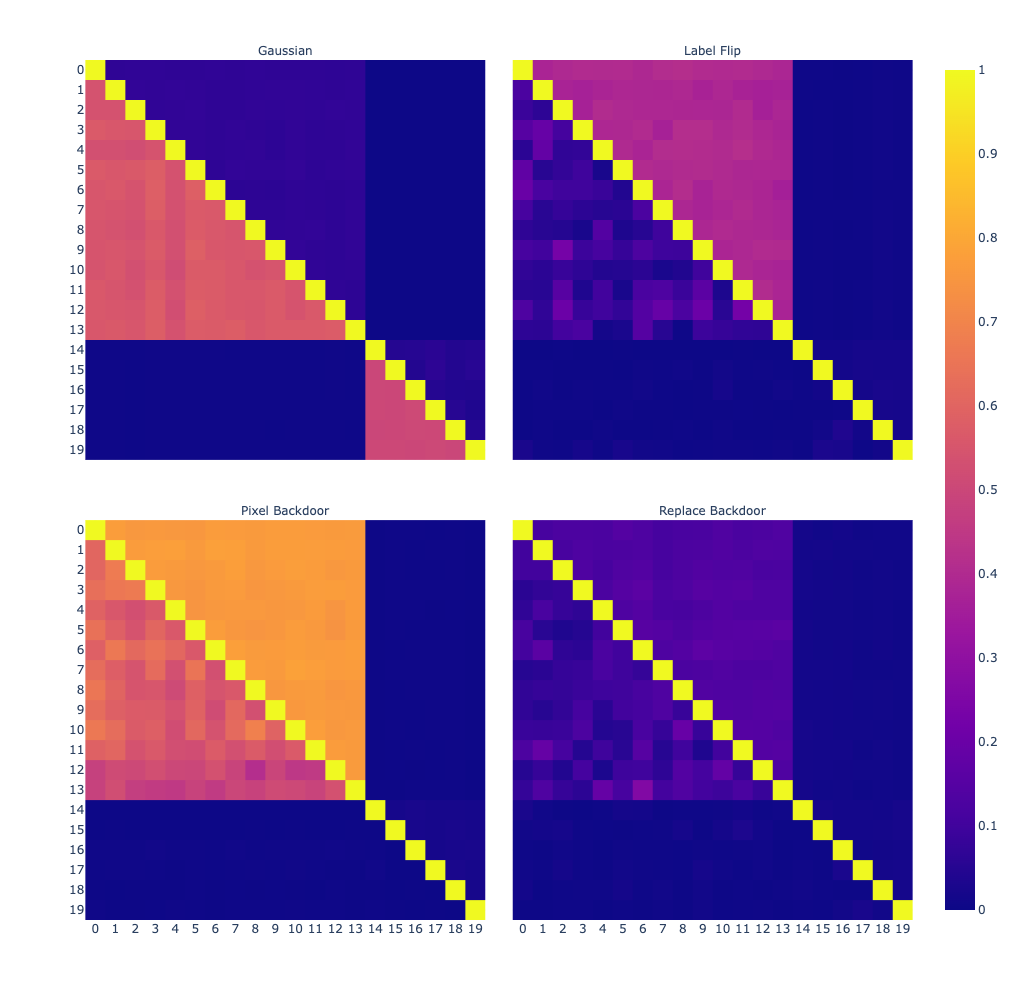

In [9]:
# 绘制热力图
datass = np.array([all_data[0][0],all_data[1][0],all_data[2][0],all_data[3][0]])
fig = px.imshow(datass,facet_col=0,facet_col_wrap=2)
xx = [i for i in range(20)]
fig.update_xaxes(tickvals=xx)
fig.update_yaxes(tickvals=xx)
name = ['Pixel Backdoor','Replace Backdoor','Gaussian','Label Flip']
for i in [0,1,2,3]:
    print(fig.layout.annotations[i]['text'])
    fig.layout.annotations[i]['text'] = name[i]
fig.update_layout(height=1000,width=1000)
fig.show()
fig.write_image('./ad_heatmap_all_attack.png', scale=4)

In [6]:
# 计算密度函数
def get_P(M,dc_iid,dc_non):
    N = len(M)
    P_iid = []
    P_non = []

    # 还原non和iid矩阵
    M_iid = np.random.rand(N,N)
    M_non = np.random.rand(N,N)

    for i in range(N):
        for j in range(N):
            if i>j: #non
                M_non[i][j]=M[i][j]
                M_non[j][i]=M[i][j]
            elif i<j: #iid
                M_iid[i][j]=M[i][j]
                M_iid[j][i]=M[i][j]
            else: #对角线
                M[i][j]=M[i][j]

    for i in range(N):
        pi_iid = 0
        pi_non = 0
        for j in range(N):
            if M_iid[i][j]>dc_iid and i!=j:
                pi_iid = pi_iid + 1
            if M_non[i][j]>dc_non and i!=j:
                pi_non = pi_non + 1
        P_iid.append(pi_iid)
        P_non.append(pi_non)
    return (P_iid,P_non)


In [7]:
# 获取密度的数据类型
def mk_all_df(datas):
    N = 20
    density = []
    for i,data in enumerate(datas): # 遍历四种攻击方式
        P_ = get_P(data[0],data[1],data[2])
        density = density + P_[0]+ P_[1]
    
    distribute = (["IID"]*20+["NonIID"]*20)*4
    attack = ['Gaussian']*40+['Label Flip']*40 +['Pixel Backdoor']*40+['Replace Backdoor']*40
    client = [i for i in range(20)]*8

    df_data = pd.DataFrame()
    df_data['Attack Density']=density
    df_data['Client ID']=client
    df_data['Attack Type']=attack
    df_data['Data Distribution']=distribute

    return df_data

kk = mk_all_df(all_data)

kk

,Attack Density,Client ID,Attack Type,Data Distribution
0,13,0,Gaussian,IID
1,13,1,Gaussian,IID
2,13,2,Gaussian,IID
3,13,3,Gaussian,IID
4,13,4,Gaussian,IID
...,...,...,...,...
155,1,15,Replace Backdoor,NonIID
156,0,16,Replace Backdoor,NonIID
157,0,17,Replace Backdoor,NonIID
158,0,18,Replace Backdoor,NonIID


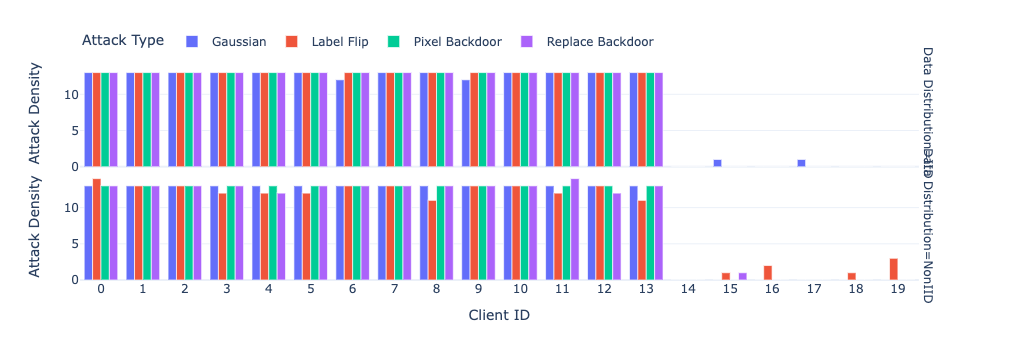

In [10]:
#绘画密度
xx = [i for i in range(20)]
fig = px.bar(kk, x="Client ID", y="Attack Density",color='Attack Type',facet_row='Data Distribution',barmode="group")
fig.update_xaxes(tickvals=xx)
fig.update_layout(legend=dict(orientation="h",y=1.15))
fig.show()
fig.write_image('./ad_attack_density.png', scale=4)